In [14]:
import os
import sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm

In [15]:
train_set = pd.read_csv("../project2_TS_input/ptbdb_train.csv", header=None)
test_set = pd.read_csv("../project2_TS_input/ptbdb_test.csv", header=None)

In [16]:
y_train=train_set.iloc[:,-1]
X_train = train_set.iloc[:,:-1]
y_test=test_set.iloc[:,-1]
X_test = test_set.iloc[:,:-1]

In [4]:
X_train_tensor = torch.tensor(X_train.values , dtype=torch.float)
y_train_tensor= torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test.values , dtype=torch.float)
y_test_tensor= torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create a DataLoader for each dataset
batch_size = 128
loader_train = DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
loader_test = DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=2911, shuffle=False)
loader_valid = DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=False)

# Vanilla simple CNN

In [17]:
class CNN(nn.Module):
    def __init__(self,classes):
        super(CNN, self).__init__()

        self.convolutions = nn.Sequential( 
                            # First conv layer to increase channel depth
                            nn.Conv1d(1, 64, kernel_size=5, stride=1, padding=2, bias=False),
                            nn.BatchNorm1d(64),
                            nn.ReLU(inplace=True),
                            # Second conv layer to downsample
                            nn.Conv1d(64, 64, kernel_size=5, stride=4, padding=1, bias=False),
                            nn.BatchNorm1d(64),
                            nn.ReLU(inplace=True),
        )
        self.fc2 = nn.Linear(64*47, classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.convolutions(x)
        flattened= torch.flatten(x, 1)
        class_scores = self.fc2(flattened)
        return class_scores

In [13]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN(1).to(device)

# Define the loss function and the optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
# train the model
def train(model, criterion, optimizer, train_loader, epochs=5, plot = True):
    '''
    Train the network and validate it at each epoch plotting the training and validation loss curves
    '''
    train_losses = []


    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for timeseries, labels in tqdm(train_loader):
            timeseries, labels = timeseries.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(timeseries)
            labels = labels.float()
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        valid_loss = 0.0

        print(f"Epoch {epoch + 1}/{epochs}.. "
              f"Train loss: {train_loss:.3f}")

    if plot:
        plt.plot(train_losses, label='Training loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    return train_losses


100%|██████████| 91/91 [00:07<00:00, 11.90it/s]


Epoch 1/10.. Train loss: 0.389


100%|██████████| 91/91 [00:06<00:00, 14.55it/s]


Epoch 2/10.. Train loss: 0.254


100%|██████████| 91/91 [00:06<00:00, 14.35it/s]


Epoch 3/10.. Train loss: 0.200


100%|██████████| 91/91 [00:08<00:00, 10.40it/s]


Epoch 4/10.. Train loss: 0.161


100%|██████████| 91/91 [00:06<00:00, 14.11it/s]


Epoch 5/10.. Train loss: 0.144


100%|██████████| 91/91 [00:06<00:00, 14.83it/s]


Epoch 6/10.. Train loss: 0.125


100%|██████████| 91/91 [00:06<00:00, 14.65it/s]


Epoch 7/10.. Train loss: 0.114


100%|██████████| 91/91 [00:07<00:00, 11.53it/s]


Epoch 8/10.. Train loss: 0.097


100%|██████████| 91/91 [00:07<00:00, 12.07it/s]


Epoch 9/10.. Train loss: 0.089


100%|██████████| 91/91 [00:06<00:00, 14.57it/s]


Epoch 10/10.. Train loss: 0.084


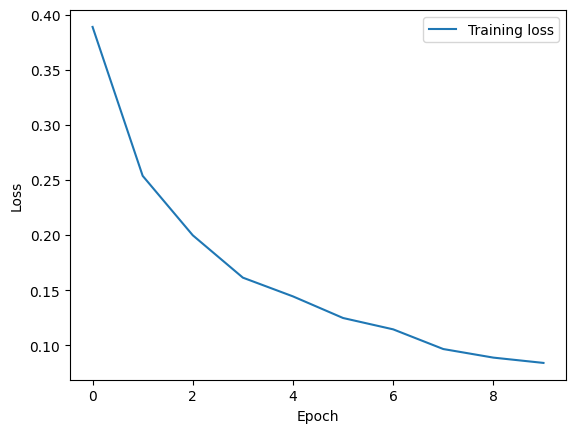

In [14]:
train_losses= train(model, criterion, optimizer, loader_train, epochs=10)

In [15]:
save_model = {
    'state_dict': model.state_dict(),
    'optimizer' : optimizer
}

torch.save(save_model, 'Part1_Q3_VanillaCNN_simple_.pth')

In [6]:
# Evaluate the model on the test set

def evaluate(model, test_loader):
    '''
    Evaluate the model on the test set
    '''
    model.eval()
    test_loss = 0.0
    correct = 0

    with torch.no_grad():
        for timeseries, labels in test_loader:
            timeseries, labels = timeseries.to(device), labels.to(device)
            output = model(timeseries)
            labels = labels.float()
            loss = criterion(output, labels)
            test_loss += loss.item()
            preds = torch.round(torch.sigmoid(output))
            correct += (preds == labels).sum().item()
            
            test_loss /= len(test_loader)
            accuracy = correct / len(test_loader.dataset)

            print(f"Test loss: {test_loss:.3f}.. "
                  f"Test accuracy: {accuracy:.3f}")

            cm = ConfusionMatrixDisplay.from_predictions(y_test, preds.numpy(), 
                                                    display_labels=['Class 0', 'Class 1'], 
                                                    cmap='Blues', 
                                                    normalize=None)

            print(classification_report(y_test, preds.numpy()))
            print("F1: ",f1_score(y_test, preds.numpy()))

    
    
    return test_loss, accuracy




Test loss: 0.113.. Test accuracy: 0.963
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93       809
         1.0       0.98      0.97      0.97      2102

    accuracy                           0.96      2911
   macro avg       0.95      0.96      0.95      2911
weighted avg       0.96      0.96      0.96      2911

F1:  0.9742120343839542


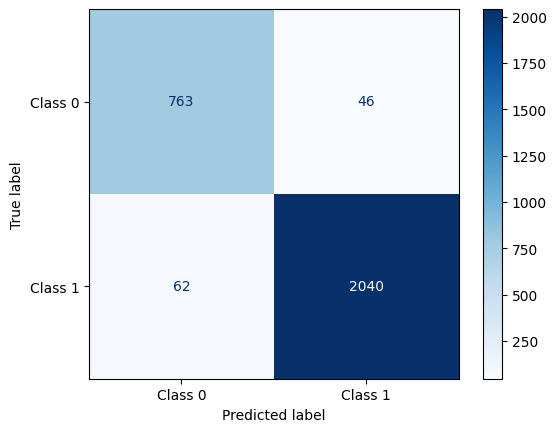

In [17]:
test_loss, test_accuracy = evaluate(model, loader_test)

# Recurrent blocks CNN

In [40]:
class CNN_R(nn.Module):
    def __init__(self, classes):
        super(CNN_R, self).__init__()

        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, stride=1, padding=2, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv1d(64, 64, kernel_size=5, stride=4, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU(inplace=True)

        self.fc2 = nn.Linear(64 * 47, classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x_add = x

        x = self.conv1(x)
        x += x_add
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        flattened = torch.flatten(x, 1)
        class_scores = self.fc2(flattened)
        
        return class_scores


In [41]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_recurrent = CNN_R(1).to(device)

# Define the loss function and the optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer_recurrent = optim.Adam(model_recurrent.parameters(), lr=0.001)

  0%|          | 0/91 [00:00<?, ?it/s]

100%|██████████| 91/91 [00:06<00:00, 13.47it/s]


Epoch 1/10.. Train loss: 0.109


100%|██████████| 91/91 [00:06<00:00, 14.43it/s]


Epoch 2/10.. Train loss: 0.100


100%|██████████| 91/91 [00:06<00:00, 13.99it/s]


Epoch 3/10.. Train loss: 0.100


100%|██████████| 91/91 [00:06<00:00, 14.30it/s]


Epoch 4/10.. Train loss: 0.086


100%|██████████| 91/91 [00:06<00:00, 14.37it/s]


Epoch 5/10.. Train loss: 0.080


100%|██████████| 91/91 [00:07<00:00, 12.55it/s]


Epoch 6/10.. Train loss: 0.077


100%|██████████| 91/91 [00:05<00:00, 15.37it/s]


Epoch 7/10.. Train loss: 0.076


100%|██████████| 91/91 [00:07<00:00, 12.62it/s]


Epoch 8/10.. Train loss: 0.066


100%|██████████| 91/91 [00:06<00:00, 13.86it/s]


Epoch 9/10.. Train loss: 0.064


100%|██████████| 91/91 [00:08<00:00, 11.20it/s]


Epoch 10/10.. Train loss: 0.060


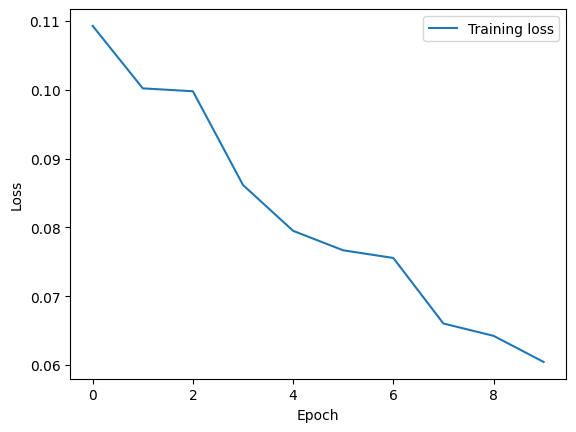

In [44]:
train_losses= train(model_recurrent, criterion, optimizer_recurrent, loader_train, epochs=10)

Test loss: 0.084.. Test accuracy: 0.975
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96       809
         1.0       0.98      0.98      0.98      2102

    accuracy                           0.98      2911
   macro avg       0.97      0.97      0.97      2911
weighted avg       0.98      0.98      0.98      2911

F1:  0.9828897338403042


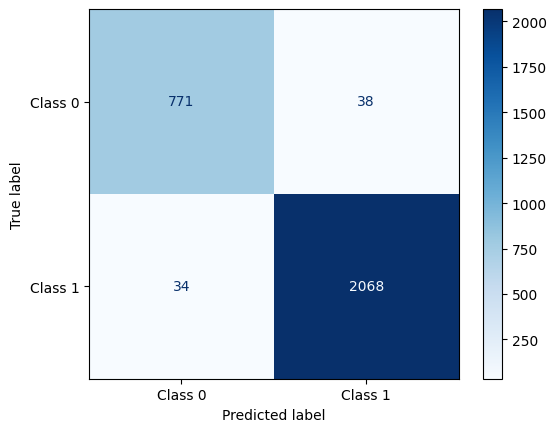

In [45]:
test_loss, test_accuracy = evaluate(model_recurrent, loader_test)

In [47]:
save_model = {
    'state_dict': model_recurrent.state_dict(),
    'optimizer' : optimizer_recurrent
}

torch.save(save_model, 'Part1_Q3_RecurrentCNN_simple_.pth')